# Imports

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import numpy as np
import requests as rs
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
from scipy.signal import spectrogram
from scipy.signal import periodogram
from scipy.signal import iirnotch
from scipy.signal import find_peaks
from scipy.signal import welch
from scipy.signal import butter
from scipy.signal import sosfilt
from scipy.stats import sem
from voltage_imaging import *

# Functions

# Parameters

In [2]:
path_dir = os.path.join('..', 'data', '20211128', 'kymograph')
cells_to_crop_end = ['20211125_M_C_5_Cell_1.mat']
threshold = 3.5
half_window = 25 #Samples
half_window_STA = 5
list_files = ['20211126_M_A_2_Cell_6_trace1.mat',
              '20211123_M_TR_3_Cell_1_circle.mat',
              '20211123_M_TR_3_Cell_2_line.mat',
              '20211126_M_C_1_Cell_2_trace1.mat',
              '20211126_M_C_1_Cell_5_trace1.mat',
              '20211126_M_C_1_Cell_1_trace3.mat']

best_examples_list = np.array(list_files)[np.array([1,2,3,5])]

# Loading file

In [3]:
all_files = np.array(os.listdir(path_dir))
valid_files = all_files[[s.endswith('.mat') for s in all_files]]

In [4]:
dict_data = dict()
for fname in valid_files:
    path = os.path.join(path_dir, fname)
    dict_data[fname] = loadmat(path, squeeze_me = True)

# Plotting all recordings

## Plots with best examples

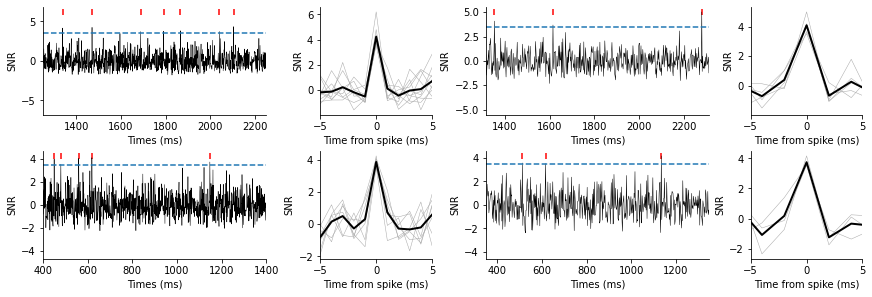

In [5]:
list_not_2_dim = list()
half_window_STA = 5

fig = plt.figure(figsize = (12, 4), constrained_layout = True)
spec = gridspec.GridSpec(ncols=6, nrows=2, figure=fig)
cursor_figure = 1

pdf_name = 'best_examples_final.pdf'

xlim_list = [(1250,2250), (400,1400), (1315, 2315), (350,1350)]
# xlim_list = None

for idx_file, fname in enumerate(best_examples_list):

    cur_file = dict_data[fname]

    data = getDataKymo(cur_file)
    signal = data[1,:]

    if data.shape[0] != 2:
        list_not_2_dim.append(fname)    
        continue

    fs = len(data[0,:])/(data[0,-1] - data[0,0]) #kHz   

    #Zscore
    # plt.subplot(nrow, ncol, cursor_figure)
    start_spec = int(0+3*(idx_file//2))
    end_spec = start_spec + 2
    cur_ax = fig.add_subplot(spec[idx_file%2, start_spec:end_spec])

    zscore_val = movingZscore(signal, half_window, True)
    extreme_val = 1.1*np.max([np.max(np.abs(zscore_val)),threshold])
    peaks = peakDetection(zscore_val, threshold)
    # peaks_neg = peakDetection(zscore_val, threshold, invert_signal = True)
    time_axis = data[0,half_window:-half_window]
    plt.plot(time_axis, zscore_val, c = 'k', linewidth = 0.5)
    plt.scatter(time_axis[peaks], [0.9*extreme_val]*len(peaks), c = 'r', marker = '|')
    # plt.scatter(time_axis[peaks_neg], [-0.9*extreme_val]*len(peaks_neg), c = 'blue', marker = '|')
    plt.ylim(-extreme_val, extreme_val)
    plt.axhline(threshold, linestyle = '--')
    # plt.axhline(-threshold, linestyle = '--')            
    plt.xlabel('Times (ms)')
    plt.ylabel('SNR')
    if xlim_list is not None:
        plt.xlim(xlim_list[idx_file])
    cursor_figure += 1  
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    #Spike shape
    start_spec = int(3*(idx_file//2)+2)
    cur_ax = fig.add_subplot(spec[idx_file%2, start_spec])
    if len(peaks) > 0:
        mat_STA = np.zeros(shape = (len(peaks), 2*half_window_STA + 1))
        keep_row = np.ones(len(peaks), dtype = 'bool')
        for i,p in enumerate(peaks):
            vect = zscore_val[p-half_window_STA:p+half_window_STA+1]
            if len(vect) == 2*half_window_STA + 1:
                mat_STA[i,0:len(vect)] = vect
            else:
                keep_row[i] = False
        mat_STA = mat_STA[keep_row,:]
        ts = np.linspace(-half_window_STA/fs, half_window_STA/fs, num = mat_STA.shape[1])
        plt.plot(ts,mat_STA.T, c = 'darkgray', linewidth = 0.5)
        plt.plot(ts,np.mean(mat_STA, axis = 0), c = 'black', linewidth = 2)
        plt.xlabel('Time from spike (ms)')
        plt.ylabel('SNR')
        plt.xlim(-5,5)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
    cursor_figure += 1   


plt.savefig('best_example_1000ms.png', dpi = 300)
    

## Comparison of constructs

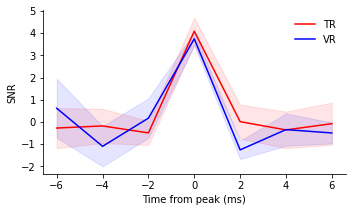

In [6]:
half_window_STA = 3

fig = plt.figure(figsize = (5, 3), tight_layout = 3)
pdf_name = 'overlay_spike_shape.pdf'

list_VR = list()
list_TR = list()

# for idx_file,fname in enumerate(list_files):
for idx_file, fname in enumerate(best_examples_list):

    cur_file = dict_data[fname]

    data = getDataKymo(cur_file)
    signal = data[1,:]

    fs = len(data[0,:])/(data[0,-1] - data[0,0]) #kHz   

    #Zscore
    zscore_val = movingZscore(signal, half_window, True)
    extreme_val = 1.1*np.max([np.max(np.abs(zscore_val)),threshold])
    peaks = peakDetection(zscore_val, threshold)

    #Spike shape
    if len(peaks) > 0:
        mat_STA = np.zeros(shape = (len(peaks), 2*half_window_STA + 1))
        keep_row = np.ones(len(peaks), dtype = 'bool')
        for i,p in enumerate(peaks):
            #1 kHz case
            if idx_file in [1,2]:
                vect = zscore_val[[p + int(v) for v in np.linspace(-2*half_window_STA, 2*half_window_STA, num = 2*half_window_STA + 1)]]
            #500 Hz case
            else:
                vect = zscore_val[p-half_window_STA:p+half_window_STA+1]
            if len(vect) == 2*half_window_STA + 1:
                mat_STA[i,0:len(vect)] = vect
            else:
                keep_row[i] = False
        mat_STA = mat_STA[keep_row,:]

        if idx_file <= 2:
            list_TR.append(mat_STA)
        else:
            list_VR.append(mat_STA)

for i,cur_list in enumerate([list_TR, list_VR]):
    r_count = 0
    for l in cur_list:
        r_count += l.shape[0]
    merge_matrix = np.zeros(shape = (r_count, l.shape[1]))
    cursor = 0
    for l in cur_list:
        merge_matrix[cursor:cursor+l.shape[0]] = l
        cursor += l.shape[0]

    mval = np.mean(merge_matrix, axis = 0)
    std = np.std(merge_matrix, axis = 0)

    cur_col = 'red' if i == 0 else 'blue'

    ts = np.linspace(-2*half_window_STA, 2*half_window_STA, len(mval))
    plt.plot(ts, mval, c = cur_col)
    plt.fill_between(ts, mval + std, mval - std, color = cur_col, alpha = 0.1)
    plt.xlabel('Time from peak (ms)')
    plt.ylabel('SNR')
    plt.legend(['TR', 'VR'], frameon = False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)


plt.savefig('VR_TR.png', dpi = 300)

# Methods part

## Raw data

In [7]:
meta = loadMeta()
dict_data = dict()
for fname in meta['File'].unique():
    path = os.path.join('..', 'data', fname.split('_')[0], fname + '.mes')
    dict_data[fname] = loadmat(path, squeeze_me = True)

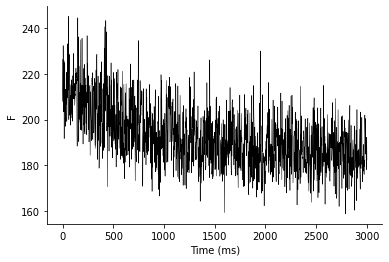

In [62]:
fig = plt.figure(figsize = (5,6), tight_layout = 2)
meta_plot = meta.query('(File == "20211125_M_B_1") & (Measure_ID == 10)')
row = meta_plot.iloc[0]
data = getRecordingData(dict_data, row)
ax = plt.imshow(data.T, vmax = 200, vmin = 130, extent = [0, 100, 3000, 0], aspect = 'auto')
plt.xlabel('Line position (%)')
plt.ylabel('Time (ms)')
plt.colorbar(ax, label = 'F')
plt.savefig('figure_method_01.png', dpi = 100)

plt.axvline(100*row['Kymo_start']/data.shape[0], c = 'r', linestyle = '--', linewidth = 1.5)
plt.axvline(100*row['Kymo_end']/data.shape[0], c = 'r', linestyle = '--', linewidth = 1.5)
plt.savefig('figure_method_02.png', dpi = 100)

plt.close()
plt.figure()
signal = np.mean(data[int(row['Kymo_start']):int(row['Kymo_end']),:], axis = 0)
ts = np.linspace(0, 3000, num = len(signal))
plt.plot(ts, signal, c = 'black', linewidth = 0.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('F')
plt.xlabel('Time (ms)')
plt.savefig('figure_method_03.png', dpi = 300)

## Bleaching

In [68]:
def movingMeanSub(signal, half_window_size = 25):
    
    vect_zscored = np.zeros(len(signal) - 2*half_window_size)
    for i in range(len(vect_zscored)):
        start_point = i
        end_point = i+2*half_window_size+1
        sub_signal = signal[start_point:end_point]        
        vect_zscored[i] = (signal[i+half_window_size] - np.mean(sub_signal))         
    return(vect_zscored)

plt.figure()
signal_substracted = movingMeanSub(signal)
ts = np.linspace(50, 2950, num = len(signal_substracted))
plt.plot(ts, signal_substracted, c = 'black', linewidth = 0.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('F')
plt.xlabel('Time (ms)')
plt.savefig('figure_method_04.png', dpi = 300)
plt.close()




## SNR and spikes

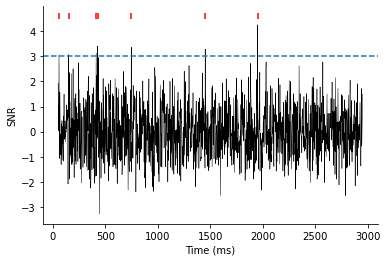

In [92]:
threshold = 3
plt.figure()
signal_SNR = signal_substracted / np.std(signal_substracted)
ts = np.linspace(50, 2950, num = len(signal_substracted))
plt.plot(ts, signal_SNR, c = 'black', linewidth = 0.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('SNR')
plt.xlabel('Time (ms)')
plt.savefig('figure_method_05.png', dpi = 300)

#Threshold
peaks = peakDetection(signal_SNR, threshold)
extreme_val = 1.2*np.max(np.abs(signal_SNR))
plt.axhline(threhsold, linestyle = '--')
plt.scatter(ts[peaks], [0.9*extreme_val]*len(peaks), c = 'r', marker = '|')
plt.savefig('figure_method_06.png', dpi = 300)

## Spike waveform

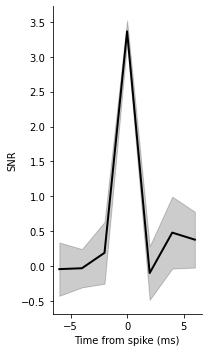

In [112]:
plt.figure(figsize = (3,5), tight_layout = 3)
mat_STA = np.zeros(shape = (len(peaks), 2*half_window_STA + 1))
keep_row = np.ones(len(peaks), dtype = 'bool')
for i,p in enumerate(peaks):
    vect = signal_SNR[p-half_window_STA:p+half_window_STA+1]
    if len(vect) == 2*half_window_STA + 1:
        mat_STA[i,0:len(vect)] = vect
    else:
        keep_row[i] = False
mat_STA = mat_STA[keep_row,:]
ts = np.linspace(-half_window_STA/fs, half_window_STA/fs, num = mat_STA.shape[1])
mval = np.mean(mat_STA, axis = 0)
plt.plot(ts,mat_STA.T, c = 'darkgray', linewidth = 0.5)
plt.plot(ts,mval, c = 'black', linewidth = 2)
plt.xlabel('Time from spike (ms)')
plt.ylabel('SNR')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('figure_method_07.png', dpi = 300)
plt.close()

plt.figure(figsize = (3,5), tight_layout = 3)
plt.plot(ts,mval, c = 'black', linewidth = 2)
# std = np.std(mat_STA, axis = 0)
std = sem(mat_STA, axis = 0)
plt.fill_between(ts, mval - std, mval + std, alpha = 0.2, color = 'black')
plt.xlabel('Time from spike (ms)')
plt.ylabel('SNR')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('figure_method_08.png', dpi = 300)

In [115]:
30*512*512/1e6

7.86432